###### 27-04-2020
###### by Jacob Fivelsdal (61008) & Niklas Hjort (60618)

# Chicago Crime

The Chicago police department is searching for a deeper understanding of the crimes committed in Chicago. \
Due to staff constraints, the department has initiated many different initiatives. One of these is to analyze data collected during the years and thereby optimize the police effort in different locations.

Furthermore, the police commissioner wants to know when he needs the most police officers in duty to respond to the peak crime activity. Another issue the police department is struggling with is that they don’t bring the correct tools to handle the different crime situations. Therefore, a categorization of the most typical crime within different time periods and areas is urgently needed. 

**Chicago Crime:** *unique_key, case_number, date, block, iucr, primary_type, Description of crime, location_description, arrest, domestic, Beat, district  ward, community_area, fbi_code, x_coordinate, y_coordinate, year, updated, Date and time, latitude, longitude, location.*

Provided Chicago data sheet is publicly available and can be found here - and to be exported to CSV for Excel (Europe):\
https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2

https://data.cityofchicago.org/Public-Safety/Crimes-2019/w98m-zvie

In [1]:
# Importing libraries:

library(ggmap)
library(ggplot2)
library(tidyverse)
library(dplyr)
library(scales)
library(lubridate)
library(TSA)
library(forecast)
install.packages("corrgram")
library(corrgram)
library(cowplot)

Loading required package: ggplot2
Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.
Please cite ggmap if you use it! See citation("ggmap") for details.
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.1.3     ✔ purrr   0.3.3
✔ tidyr   1.0.2     ✔ dplyr   0.8.4
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ tibble  2.1.3     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor


Attaching package: ‘lubridate’

The following objects are masked from ‘package:dplyr’:

    intersect, setdiff, union

The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Attaching package: ‘TSA’

The following object is masked from

# Table of content

- Data Cleaning
- Exploratory Data Analysis
  - Boxplot
  - Crime Type occurenses
  - Number of yearly arrests
  - Effectiveness of the police work depending on type
- Time Series Analysis
  - Seasonal decomposition
  - Forecast
  - Annual plots
  - Conclussion
- Cluster Analysis
  - Plotting police station location.
  - Conclussion
- Data storage
- Ethical Discussion 
- Final Conclussion

# Data cleaning

In [2]:
dtOne <-read.csv('crimes_2015-2018.csv')
dtOne$X <- NULL
dtTwo <- read.csv('Crimes_2019.csv')

In [3]:
#Arranging columns so they are like dtOne
dtTwo <- dtTwo %>% select(Date, Year, Description, Arrest, District, Community.Area, Longitude, Latitude, Primary.Type, X.Coordinate, Y.Coordinate)
str(dtOne)
str(dtTwo)

'data.frame':	1070219 obs. of  11 variables:
 $ Date          : Factor w/ 465861 levels "01/01/2015 01:00:00 AM",..: 360400 103635 322967 304209 289 941 250000 461688 48002 417808 ...
 $ Year          : int  2017 2017 2017 2017 2015 2017 2017 2017 2017 2017 ...
 $ Description   : Factor w/ 368 levels "$500 AND UNDER",..: 223 338 245 223 125 12 245 154 330 173 ...
 $ Arrest        : Factor w/ 2 levels "false","true": 1 1 1 1 1 1 1 1 1 1 ...
 $ District      : int  22 8 3 1 8 10 14 1 6 17 ...
 $ Community.Area: int  73 70 42 32 65 30 22 32 44 13 ...
 $ Longitude     : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Latitude      : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Primary.Type  : Factor w/ 34 levels "ARSON","ASSAULT",..: 6 4 33 6 24 24 33 10 7 26 ...
 $ X.Coordinate  : int  NA NA NA NA NA NA NA NA NA NA ...
 $ Y.Coordinate  : int  NA NA NA NA NA NA NA NA NA NA ...
'data.frame':	258335 obs. of  11 variables:
 $ Date          : Factor w/ 126739 levels "01/01/2019 01:00:00 AM",..: 116549 

In [4]:
#Merging
Dataset <- rbind(dtOne, dtTwo)

In [5]:
any(is.na(Dataset))
head(Dataset)

[1] TRUE

Date,Year,Description,Arrest,District,Community.Area,Longitude,Latitude,Primary.Type,X.Coordinate,Y.Coordinate
10/08/2017 03:00:00 AM,2017,NON-AGGRAVATED,false,22,73,NA,NA,CRIM SEXUAL ASSAULT,NA,NA
03/28/2017 02:00:00 PM,2017,UNLAWFUL ENTRY,false,8,70,NA,NA,BURGLARY,NA,NA
09/09/2017 08:17:00 PM,2017,OVER $500,false,3,42,NA,NA,THEFT,NA,NA
08/26/2017 10:00:00 AM,2017,NON-AGGRAVATED,false,1,32,NA,NA,CRIM SEXUAL ASSAULT,NA,NA
01/01/2015 12:01:00 AM,2015,CRIM SEX ABUSE BY FAM MEMBER,false,8,65,NA,NA,OFFENSE INVOLVING CHILDREN,NA,NA
01/01/2017 12:01:00 AM,2017,AGG SEX ASSLT OF CHILD FAM MBR,false,10,30,NA,NA,OFFENSE INVOLVING CHILDREN,NA,NA


In [6]:
#How many NA's?
sum(is.na(Dataset))

[1] 71603

In [7]:
#Where are there NA's? We will only remove NA's if they're at specific columns that we work with eg coordinates
colSums(is.na(Dataset)) 

Date           Year    Description         Arrest       District 
             0              0              0              0              1 
Community.Area      Longitude       Latitude   Primary.Type   X.Coordinate 
             6          17899          17899              0          17899 
  Y.Coordinate 
         17899

Converting date via. lubridate to the "date" format.

In [8]:
Dataset$Date <- as.character(Dataset$Date)
Dataset$Date = substr(Dataset$Date,1,nchar(Dataset$Date)-11)
mdy("January 15, 2015")
Dataset$Date <- mdy(Dataset$Date)
Dataset$Date <- as.Date(as.character(Dataset$Date))

[1] "2015-01-15"

In [9]:
#test == Approved
str(Dataset)
colSums(is.na(Dataset)) 

'data.frame':	1328554 obs. of  11 variables:
 $ Date          : Date, format: "2017-10-08" "2017-03-28" ...
 $ Year          : int  2017 2017 2017 2017 2015 2017 2017 2017 2017 2017 ...
 $ Description   : Factor w/ 371 levels "$500 AND UNDER",..: 223 338 245 223 125 12 245 154 330 173 ...
 $ Arrest        : Factor w/ 2 levels "false","true": 1 1 1 1 1 1 1 1 1 1 ...
 $ District      : int  22 8 3 1 8 10 14 1 6 17 ...
 $ Community.Area: int  73 70 42 32 65 30 22 32 44 13 ...
 $ Longitude     : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Latitude      : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Primary.Type  : Factor w/ 34 levels "ARSON","ASSAULT",..: 6 4 33 6 24 24 33 10 7 26 ...
 $ X.Coordinate  : int  NA NA NA NA NA NA NA NA NA NA ...
 $ Y.Coordinate  : int  NA NA NA NA NA NA NA NA NA NA ...


Date           Year    Description         Arrest       District 
             0              0              0              0              1 
Community.Area      Longitude       Latitude   Primary.Type   X.Coordinate 
             6          17899          17899              0          17899 
  Y.Coordinate 
         17899

We will only remove NA's if we are working with dataframes in which columns contains empty fields. Therefore we do not remove them in this section, but only when it's needed. 


## Exploratory Data Analysis


In this section we will look at both a cumulated crime frequency during the years of 2015 to 2019 and types of crimes occurrences. This will then subside to effectivenes of the policework in arrests and a detailed time series analysis. 


In [10]:
#Removes one crazy outlier
allCrimeDs = filter(Dataset, Longitude >- 91)
#Remove NA's in this dataset
drop_na(allCrimeDs)


,Date,Year,Description,Arrest,District,Community.Area,Longitude,Latitude,Primary.Type,X.Coordinate,Y.Coordinate
1,2015-03-19,2015,SIMPLE,false,12,31,-87.67956,41.85396,ASSAULT,1162361,1890051
2,2015-03-19,2015,SIMPLE,false,19,5,-87.68825,41.94229,ASSAULT,1159750,1922221
3,2015-03-20,2015,$500 AND UNDER,false,6,44,-87.61233,41.74502,THEFT,1181008,1850499
4,2015-03-20,2015,SIMPLE,false,25,19,-87.76830,41.92079,ASSAULT,1138023,1914232
5,2015-03-21,2015,SIMPLE,true,3,69,-87.61037,41.76307,BATTERY,1181489,1857081
6,2015-03-20,2015,SIMPLE,false,14,22,-87.69772,41.92481,ASSAULT,1157222,1915830
7,2015-03-22,2015,GAME/DICE,true,10,29,-87.71242,41.85454,GAMBLING,1153407,1890195
8,2015-03-20,2015,SIMPLE,false,3,43,-87.58212,41.76974,ASSAULT,1189175,1859580
9,2015-03-17,2015,OVER $500,false,5,49,-87.62210,41.69908,THEFT,1178480,1833739
10,2015-03-23,2015,SIMPLE,false,15,25,-87.74942,41.89135,ASSAULT,1143236,1903538


We will find the frequency of all crimes. This is done by looking at each date and merging the numbers of crimes to each day. and turning the dates in to a numeric value. 

In [11]:
#Finds the frequency
tableFreq <- transform(table(allCrimeDs$Date))
names(tableFreq) <- c("Dates","Freq")
crimeFreq <- as.data.frame(tableFreq)
crimeFreq$Dates <- as.numeric(crimeFreq$Dates)


We use a boxplot to find outliers in the dataset and visually represent the five statistical number summary in the dataset. 
This includes:
* Minimum
* First quartile
* Median
* Third quartile
* Maximum

We will then use the quantiles later in times series analysis when plotting

     Dates             Freq      
 Min.   :   2,0   Min.   :508,0  
 1st Qu.: 463,0   1st Qu.:670,0  
 Median : 915,0   Median :723,0  
 Mean   : 915,9   Mean   :720,1  
 3rd Qu.:1369,0   3rd Qu.:775,0  
 Max.   :1826,0   Max.   :931,0  

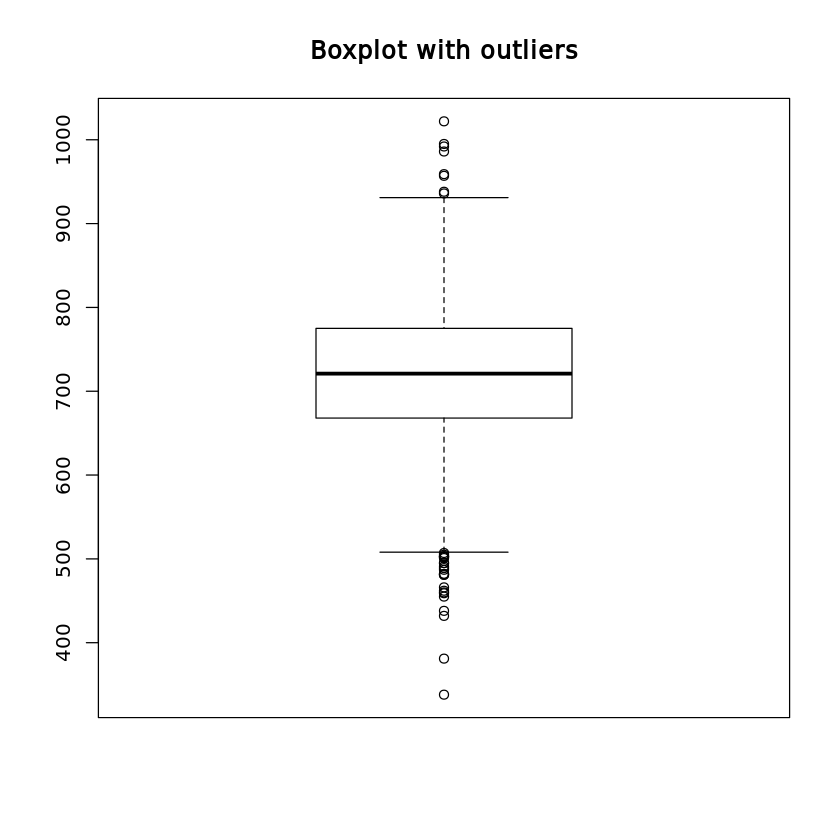

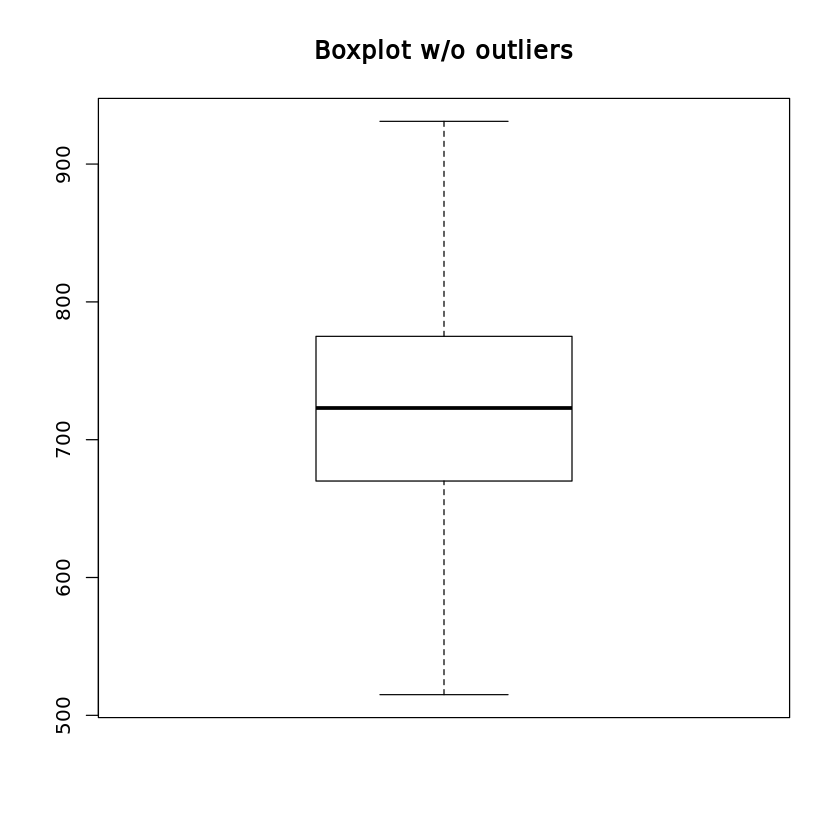

In [12]:
#Boxplot og fjerner outliers
boxplot(crimeFreq$Freq, main="Boxplot with outliers")
outliers <- boxplot(crimeFreq$Freq, plot=FALSE)$out
outliers <- crimeFreq[-which(crimeFreq$Freq %in% outliers),]
summary(outliers)
boxplot(outliers$Freq, outline=F, main="Boxplot w/o outliers")


## Crime frequency depending on type

The chicago police department wants to get an overview of the crimes commited over the last couple of years in chicago depending on the type. This is important for the purpose of where they need to provide special attention in the form of staff and prioritizing police responds.

Firstly we safe the needed columns from our dataset to the dataframe ptData. Then we use the str function to get an overview. Last we check for NA's

In [13]:
ptData <- Dataset %>% select(Date, Primary.Type, Arrest, Year)
str(ptData)
colSums(is.na(ptData)) 

'data.frame':	1328554 obs. of  4 variables:
 $ Date        : Date, format: "2017-10-08" "2017-03-28" ...
 $ Primary.Type: Factor w/ 34 levels "ARSON","ASSAULT",..: 6 4 33 6 24 24 33 10 7 26 ...
 $ Arrest      : Factor w/ 2 levels "false","true": 1 1 1 1 1 1 1 1 1 1 ...
 $ Year        : int  2017 2017 2017 2017 2015 2017 2017 2017 2017 2017 ...


Date Primary.Type       Arrest         Year 
           0            0            0            0

Now we want to have look of how many occurenses there exist of the different types in our dataframe. 
Then we want to safe count into a table. We use the c to define columns.

In [14]:
table(ptData$Primary.Type)
primTypeCount <- setNames(data.frame(table(ptData$Primary.Type)), c("Primary.Type" , "count"))


                            ARSON                           ASSAULT 
                             2160                             96089 
                          BATTERY                          BURGLARY 
                           247699                             61833 
CONCEALED CARRY LICENSE VIOLATION               CRIM SEXUAL ASSAULT 
                              505                              7775 
                  CRIMINAL DAMAGE           CRIMINAL SEXUAL ASSAULT 
                           143209                               109 
                CRIMINAL TRESPASS                DECEPTIVE PRACTICE 
                            33244                             92088 
                         GAMBLING                          HOMICIDE 
                             1033                              3068 
                HUMAN TRAFFICKING  INTERFERENCE WITH PUBLIC OFFICER 
                               58                              6183 
                     INTIMIDATION

In [15]:
str(primTypeCount)
primTypeCount$count <- as.numeric(primTypeCount$count)

'data.frame':	34 obs. of  2 variables:
 $ Primary.Type: Factor w/ 34 levels "ARSON","ASSAULT",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ count       : int  2160 96089 247699 61833 505 7775 143209 109 33244 92088 ...


Now we want plot primTypeCount. The plot needs to have labels so we can express the number of occurenses with an exact number while the bars visualizes the diffences. 

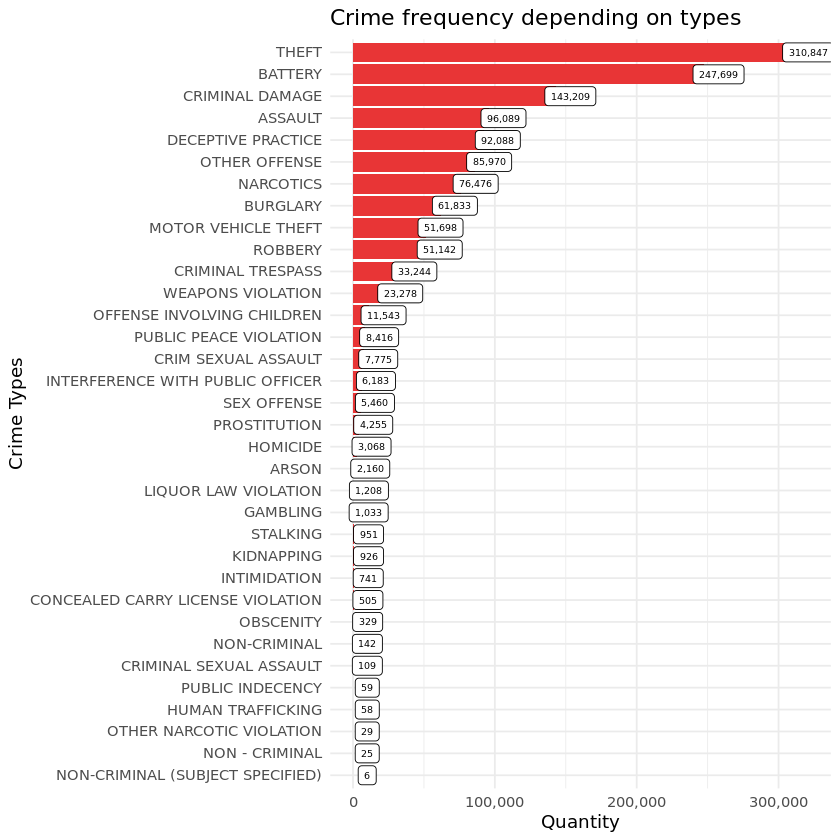

In [16]:
#scales package in use to assign a prober value for the y-axis.
ggplot(primTypeCount, mapping = aes(x = reorder(Primary.Type, count) , y = count)) +
  scale_y_continuous(labels = scales::comma) +
  coord_flip() +
  labs(x = "Crime Types", y = "Quantity", title = "Crime frequency depending on types") +
  theme_minimal() +
  geom_col(fill = "#E83536") +
  geom_label(aes(label = scales::comma(count)), size = 2.0, nudge_y = 10000)


We can conclude that theft and battery are the two most extreme forms of commited crime types within chicago. We have also provided an overview of crime activity depending on type. 

# Arrests

Another barplot that should be provided to the chicago police is to map the evolution in the number crimes commited between 2015 - 2019. They also need the information of how many arrests that have taken place. 

First we safe the needed columns into a dtaframe and check for NA's

In [17]:
ArrestData <- Dataset %>% select(Arrest, Primary.Type, Year) 
ArrestData$Year <- as.factor(ArrestData$Year)
colSums(is.na(ArrestData)) 

Arrest Primary.Type         Year 
           0            0            0

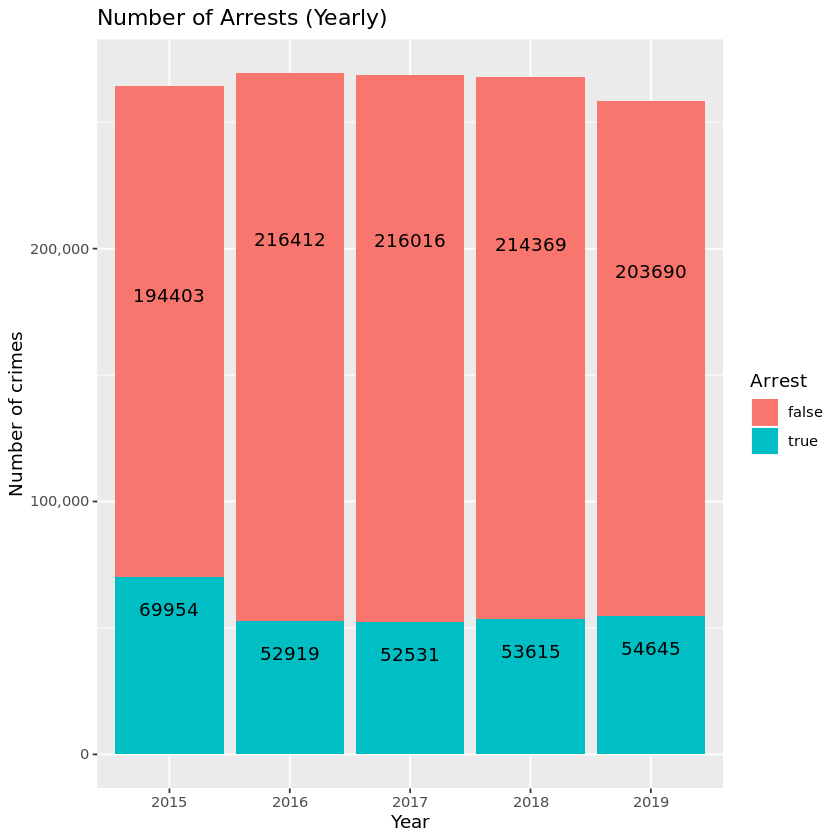

In [18]:
ggplot(ArrestData, mapping = aes(x = Year, fill = Arrest)) + 
  geom_bar() +
  scale_y_continuous(labels = scales::comma) +
  labs(y = "Number of crimes", x = "Year" , title = "Number of Arrests (Yearly)") +
  geom_text(stat='count',aes(label=..count..),vjust=3)

The plots explains that the crime activity peaked in 2016 and is lower in 2019. However the ammount of arrests performed by the police is low. This is maybe due to many unsolved cases. 

# Effectiveness of the police work

To provide an overview of the arrests. We want to make a barplot explaining the effectiveness of police work according to the different types of crimes.

In [19]:
EffectData <- ArrestData %>% select(Arrest,Primary.Type)
colSums(is.na(EffectData)) 

Arrest Primary.Type 
           0            0

To express the actual effectiveness we want to save the different arrests in an percentage variable. We are doing this below.

In [20]:
percentData <- EffectData  %>% group_by(Primary.Type) %>% count(Arrest) %>%
  mutate(ratio=scales::percent(n/sum(n)))

Checking if it's working correct.

In [21]:
head(percentData)
tail(percentData)

Primary.Type,Arrest,n,ratio
ARSON,false,1946,"90,1%"
ARSON,true,214,"9,9%"
ASSAULT,false,77986,"81,2%"
ASSAULT,true,18103,"18,8%"
BATTERY,false,195105,"78,8%"
BATTERY,true,52594,"21,2%"


Primary.Type,Arrest,n,ratio
STALKING,false,825,"86,8%"
STALKING,true,126,"13,2%"
THEFT,false,278676,"89,7%"
THEFT,true,32171,"10,3%"
WEAPONS VIOLATION,false,6383,"27,4%"
WEAPONS VIOLATION,true,16895,"72,6%"


Below we are plotting the dataframe EffectData together with percentData. We are also flipping the y and x axis and scales y with percentage instead of count. We are creating labels on top of each primary type.

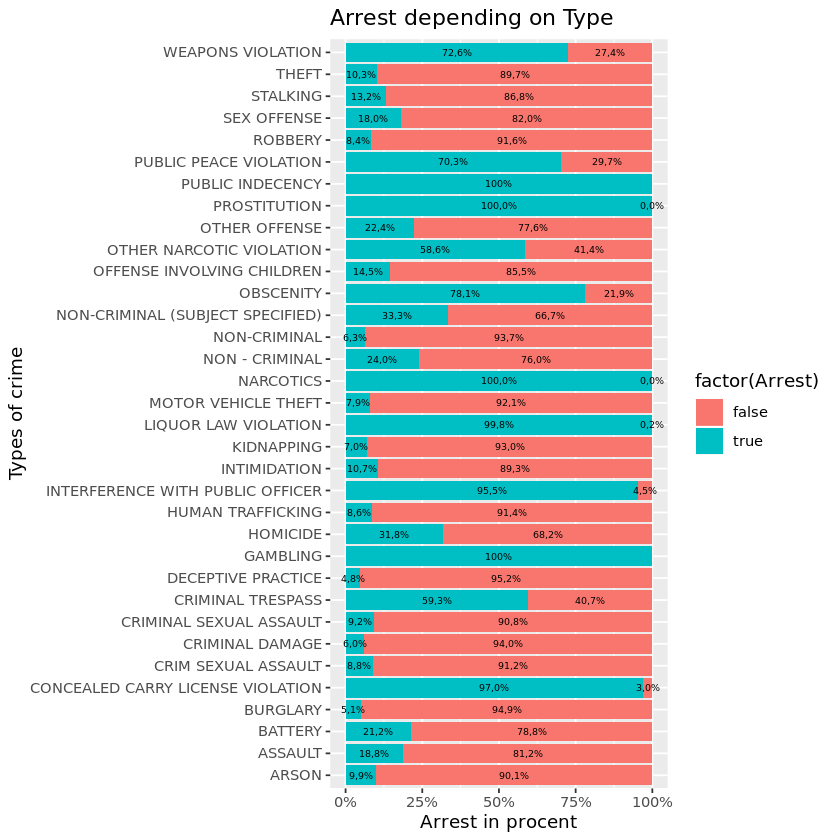

In [22]:
ggplot(EffectData,aes(x=factor(Primary.Type),fill=factor(Arrest)))+
  geom_bar(position="fill")+
  geom_text(data=percentData, aes(y=n,label=ratio), 
            position=position_fill(vjust=0.5), size = 2) +
  coord_flip() +
  scale_y_continuous(labels = scales::percent) +
  labs(x = "Types of crime", y = "Arrest in procent", title = "Arrest depending on Type")  

We can extract the following from the plot above. If we take a closer look we can conclude that for example theft has a low amount of arrest. This can be caused due to a high ammount of unsolved cases where the thief escapes. Prostitution, weapon violation and narcotics cases have a 70% or higher arrest rate, which is good compared to many other primary type. However sexual assault, battery etc. are often unsolved. 

# Time series analysis:

This section focuses on the time series with a seasonal aspect. This will end in a forecast to show how the crime frequency will develop in the future, both in a yearly value and a weekly. 

First we will transform the data to table and then to numerical values. But also because we get the frequency of a general crimes which can be saved in a table which then will be transformed to a dataframe which we will plot and correlation test

In [23]:
#Removing the quantiles
crimeFreq <- filter(crimeFreq, Freq<900)
crimeFreq <- filter(crimeFreq, Freq>510)
str(crimeFreq)


'data.frame':	1779 obs. of  2 variables:
 $ Dates: num  2 3 9 10 11 12 13 14 15 16 ...
 $ Freq : int  660 643 582 636 647 604 603 668 741 702 ...


Warning message:
“Ignoring unknown aesthetics: method, se, span”`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



	Pearson's product-moment correlation

data:  crimeFreq$Dates and crimeFreq$Freq
t = -0,2294, df = 1777, p-value = 0,8186
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0,05190309  0,04104293
sample estimates:
        cor 
-0,00544183 


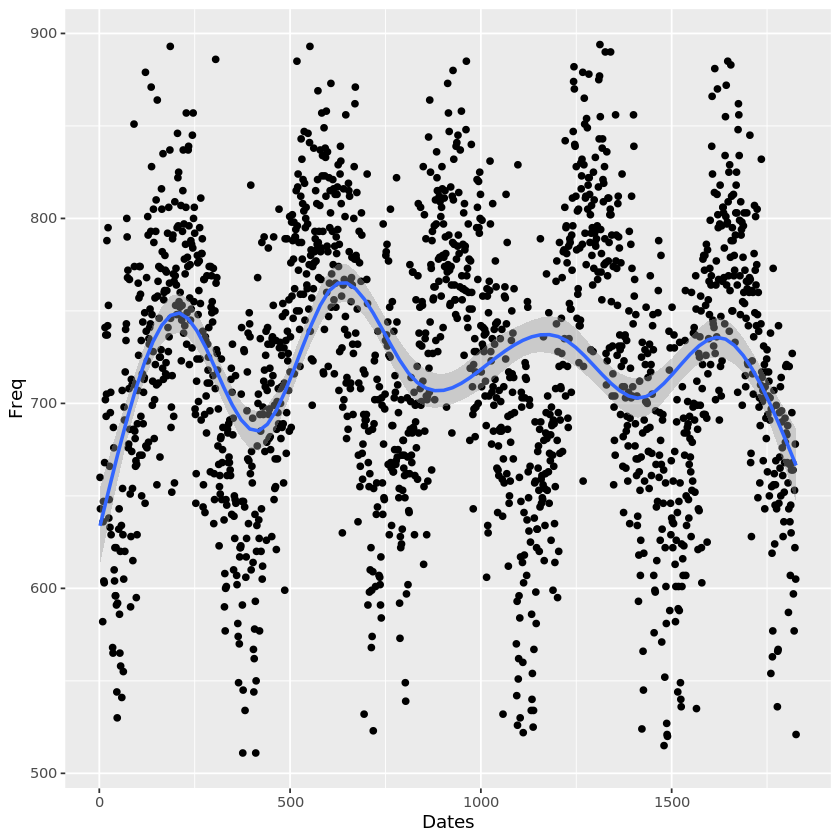

In [24]:
#crimeFreq
ggplot(data=crimeFreq)+geom_point(aes(x=Dates, y=Freq))+
  geom_smooth(aes(x=Dates, y=Freq, method = "loess", se = FALSE, span = 0.6))
cor.test(crimeFreq$Dates, crimeFreq$Freq)


We create a lmfit to see if there's any linear correlation to the data. 
As it is season data we assume there's no correlation at all and a time series analysis will be more relavant

In [25]:
#Making a lmfit
lmfit <- lm(Freq ~ Dates, data = crimeFreq)
summary(lmfit)

Warning message in printCoefmat(coefs, digits = digits, signif.stars = signif.stars, :
“NAs introduced by coercion”


Call:
lm(formula = Freq ~ Dates, data = crimeFreq)

Residuals:
     Min       1Q   Median       3Q      Max 
-209,765  -49,861    2,498   54,590  173,949 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7,211e+02  3,516e+00 205,063   <2e-16 ***
Dates       -7,627e-04  3,325e-03  -0,229    0,819    
---
Signif. codes:  0 ‘***’ 0,001 ‘**’ 0,01 ‘*’ 0,05 ‘.’ 0,1 ‘ ’ 1

Residual standard error: 73,61 on 1777 degrees of freedom
Multiple R-squared:  2,961e-05,	Adjusted R-squared:  -0,0005331 
F-statistic: 0,05262 on 1 and 1777 DF,  p-value: 0,8186


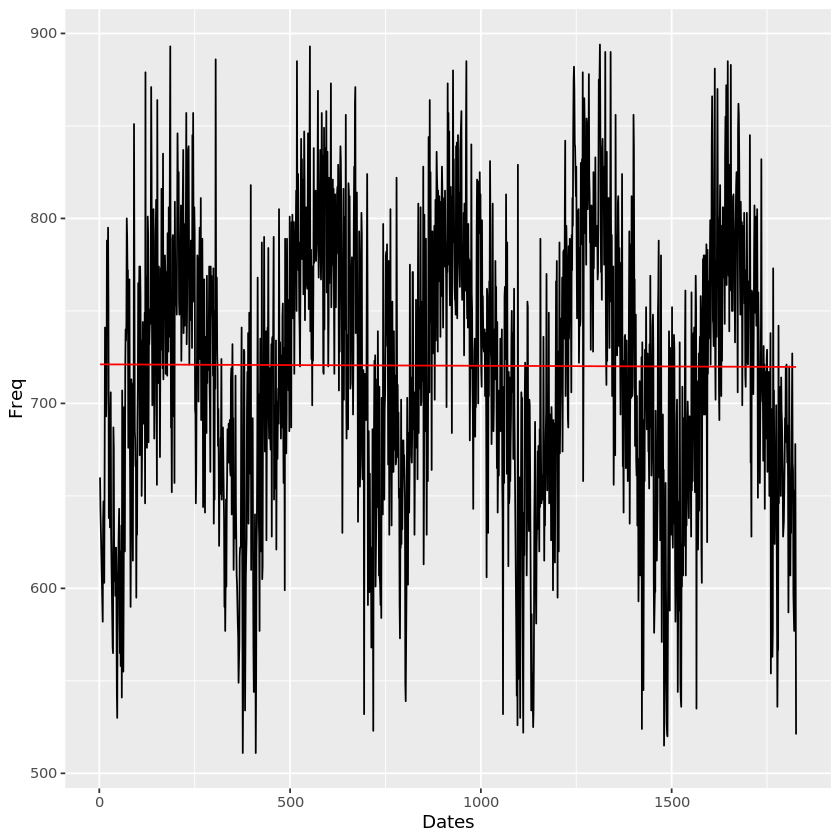

In [26]:
ggplot(crimeFreq)+
  geom_line(aes(x = Dates, y = Freq))+
  geom_line(aes(x = Dates, y = -7.627e-4*Dates+7.211e+2), color="red")


As of above we can see there's no correlation at all according to p-value and the r-squared value. Although the crime has a slight downward trend which is positive to the overall insight to crime in Chicago.



.

### Time series on yearly basis:


 Time-Series [1:1779] from 1 to 5,87: 660 643 582 636 647 604 603 668 741 702 ...


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  511,0   671,0   723,0   720,4   775,0   894,0 

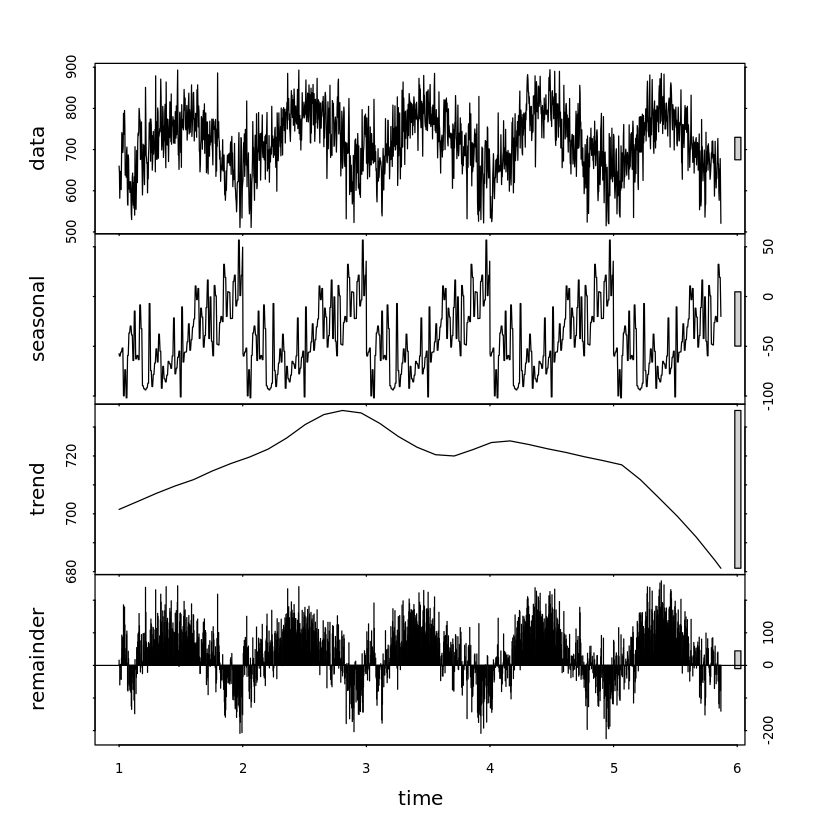

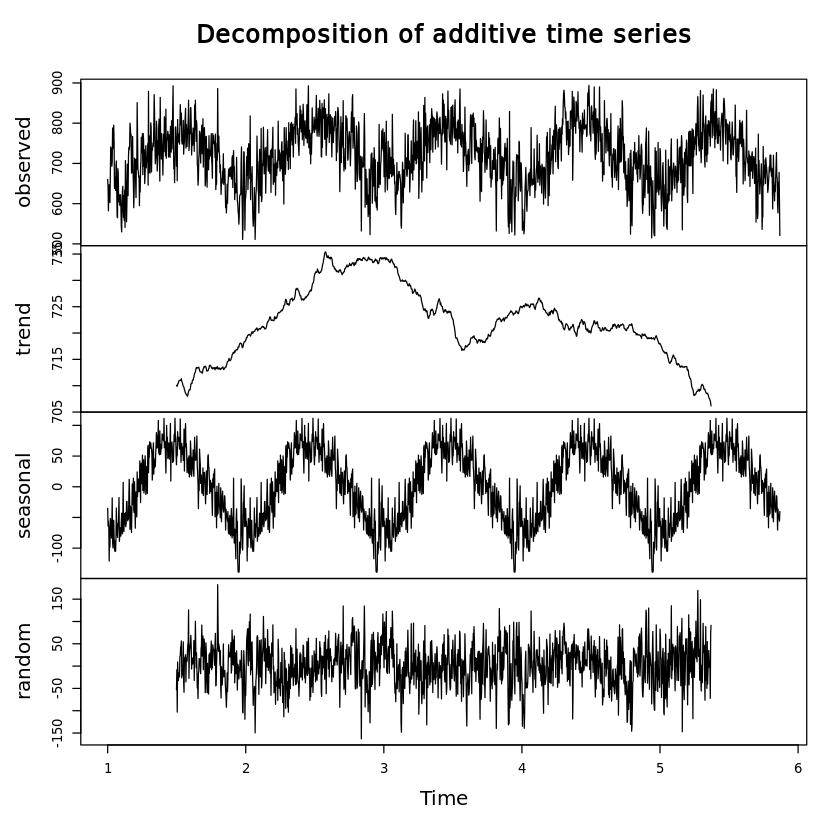

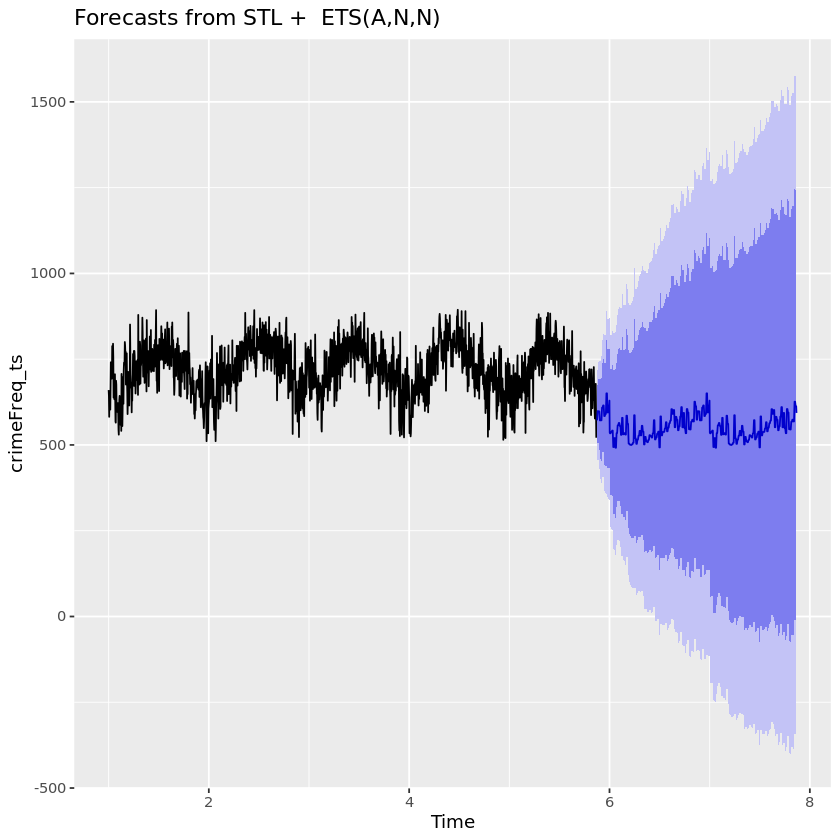

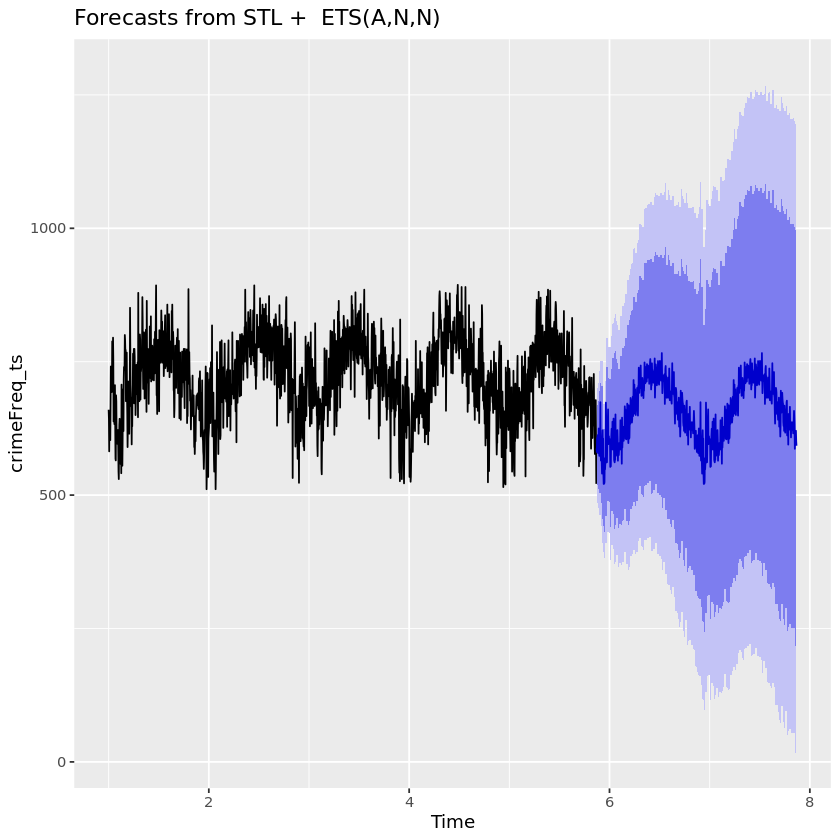

In [27]:
#Setting up dataframe with the timeseries function
crimeFreq_ts <- ts(crimeFreq$Freq, frequency = 365.25)
str(crimeFreq_ts)
summary(crimeFreq_ts)

#Seasonal Decomposition Of Time Series
plot(stl(crimeFreq_ts, s.window = "periodic"))
#Seasonal Time Series
plot(decompose(crimeFreq_ts))

#Seasonal Decomposition Of Time Series with FORECAST
autoplot(forecast(stl(crimeFreq_ts, s.window="periodic")))
#Normal autoplot with time series
autoplot(forecast(crimeFreq_ts))

##COWPLOT
#plot_grid(yearsd, yearsts, labels="AUTO")
#plot_grid(yearasd, yearsts, labels="AUTO")


As it can be seen in above we make forecasts for the next two years in a downward trend. \
Although the decomposition trends makes a wierd graph and we will then try and make a new forecast in a weekly basis.

### Time series on weekly basis:


 Time-Series [1:1779] from 1 to 35,2: 660 643 582 636 647 604 603 668 741 702 ...


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  511,0   671,0   723,0   720,4   775,0   894,0 

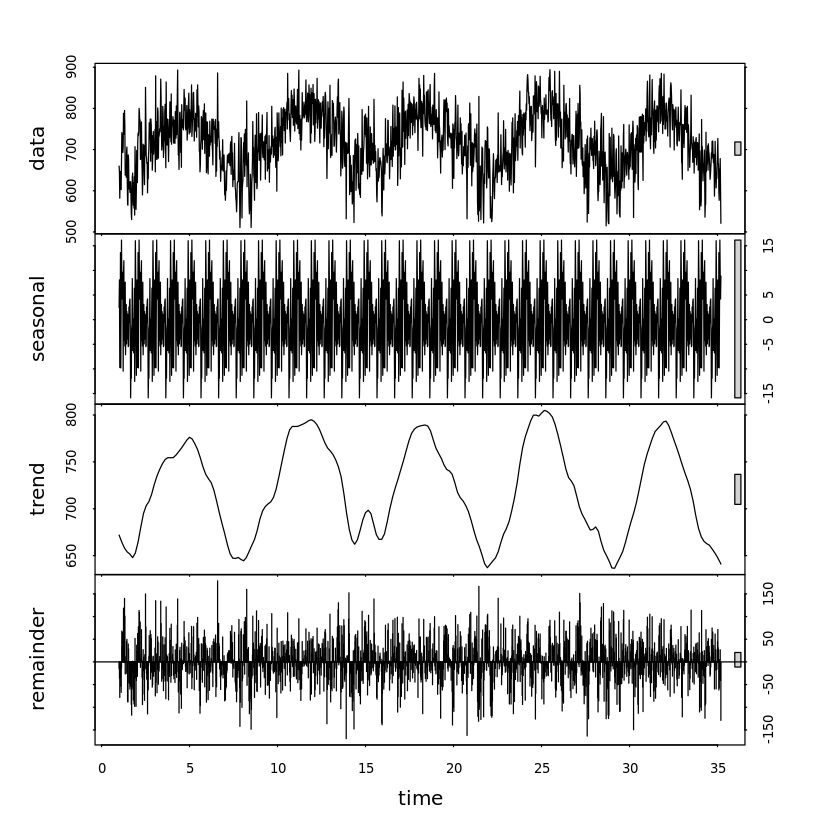

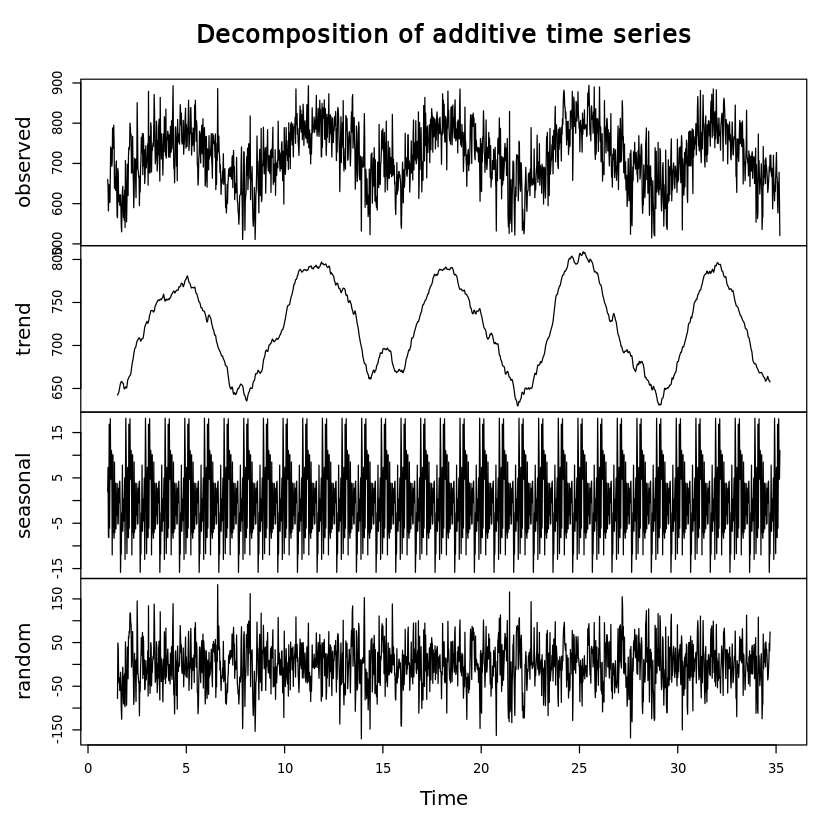

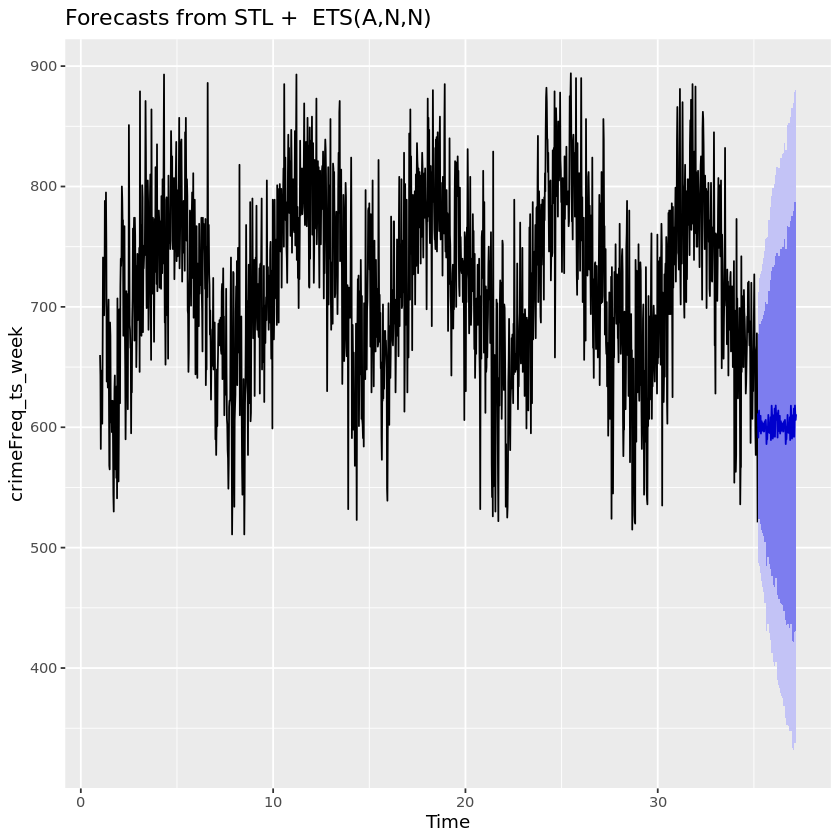

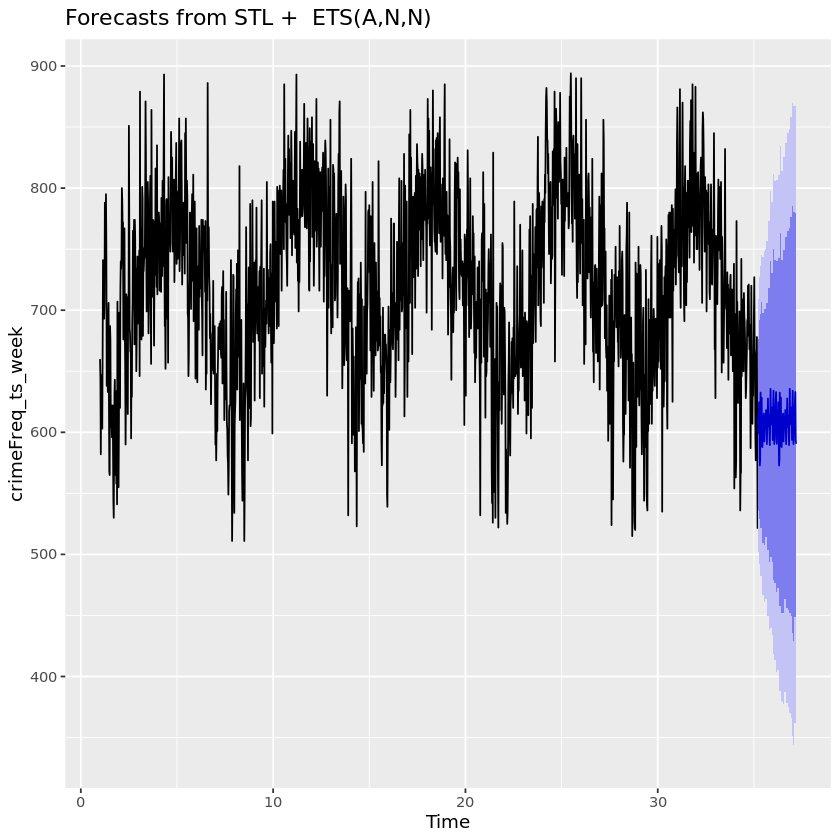

In [28]:
#Setting up data:
crimeFreq_ts_week <- ts(crimeFreq$Freq, frequency = 52)
str(crimeFreq_ts_week)
summary(crimeFreq_ts_week)

#Seasonal Decomposition Of Time Series
plot(stl(crimeFreq_ts_week, s.window = "periodic"))
#Seasonal Time Series
plot(decompose(crimeFreq_ts_week))
#Seasonal Decomposition Of Time Series with FORECAST
autoplot(forecast(stl(crimeFreq_ts_week, s.window="periodic")))
#Normal autoplot of the timeseries
autoplot(forecast(crimeFreq_ts_week))

##COWPLOT
#plot_grid(weeksd, weeksts, labels="AUTO")
#plot_grid(weekasd, weeksts, labels="AUTO")

For above the trends looks much nicer now and the forecast graphs looks great aswell for the next many weeks. 


### Barplots merged on days, months, weeks, years
Here we will look at a merged crime frequency for 2015-2019 for each day, month, week and year.


In [29]:
#Setting up data
tableFreq2 <- transform(table(allCrimeDs$Date))
names(tableFreq) <- c("Dates","Freq")
crimeFreq2 <- as.data.frame(tableFreq)
crimeFreq2$Dates <- ymd(crimeFreq2$Dates)
# First we have to change the date to POSIXct
crimeFreq2$Dates <- strptime(crimeFreq2$Dates, "%Y-%m-%d" )
crimeFreq2$Dates <- as.POSIXct(crimeFreq2$Dates)
# Now we create different columns for different time configurations
#Freq
crimeFreq2$Freq <- as.numeric(crimeFreq2$Freq)


In [30]:
# Day
crimeFreq2 <- mutate(crimeFreq2, Days = day(Dates))
crimeFreq2$Days <- as.numeric(crimeFreq2$Days)
daybar <- ggplot(data=crimeFreq2, aes(x=Days, y=Freq)) + geom_bar(stat="identity",fill="steelblue")


In [31]:
# Week
crimeFreq2 <- mutate(crimeFreq2, Weeks = week(Dates))
crimeFreq2$Days <- as.numeric(crimeFreq2$Week)
weekbar <- ggplot(data=crimeFreq2, aes(x=Weeks, y=Freq)) + geom_bar(stat="identity",fill="steelblue")


In [32]:
# Month
crimeFreq2 <- mutate(crimeFreq2, Month = month(Dates))
crimeFreq2$Month <- as.numeric(crimeFreq2$Month) 
monthbar <- ggplot(data=crimeFreq2, aes(x=Month, y=Freq)) + geom_bar(stat="identity",fill="steelblue")


In [33]:
# Year
crimeFreq2 <- mutate(crimeFreq2, Year = year(Dates))
crimeFreq2$Year <- as.numeric(as.character(crimeFreq2$Year))
yearbar <- ggplot(data=crimeFreq2, aes(x=Year, y=Freq)) + geom_bar(stat="identity",fill="steelblue") + scale_y_continuous(labels = scales::comma)

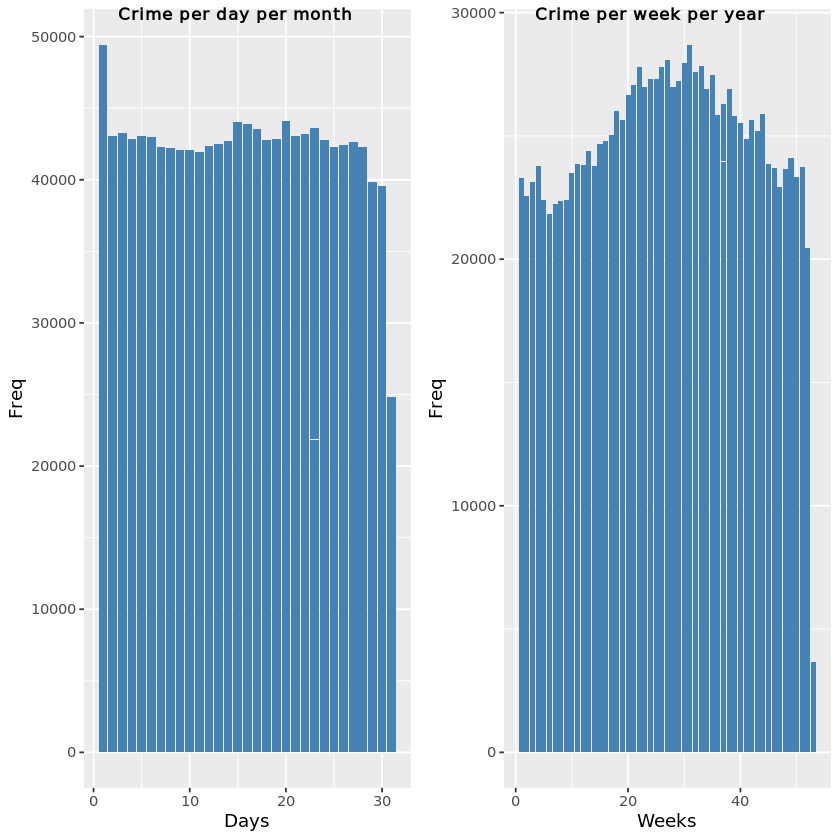

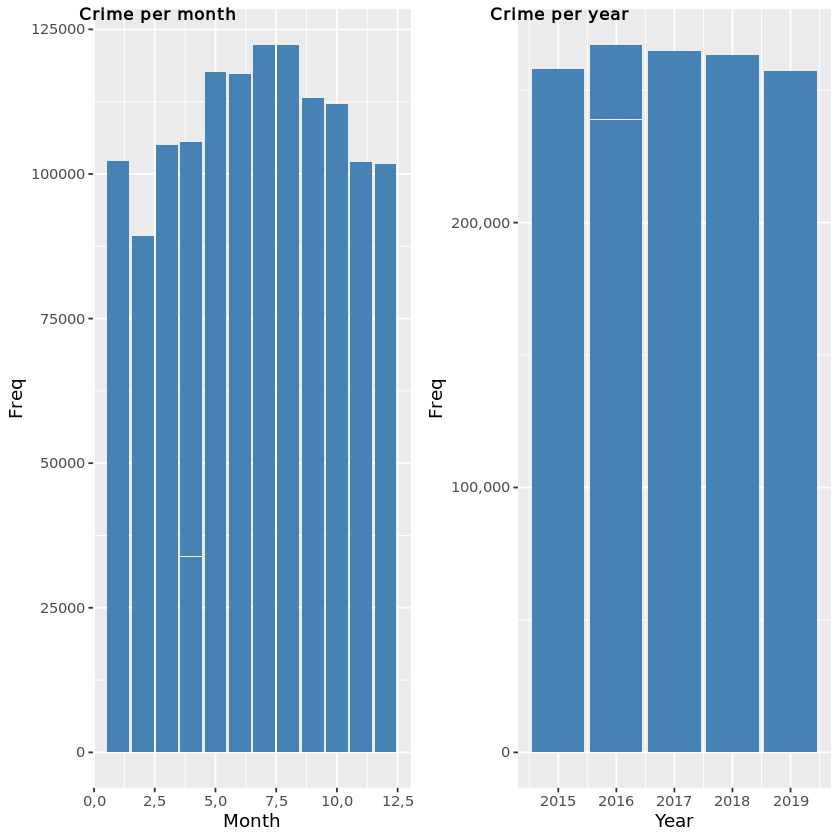

In [34]:
##COWPLOT
plot_grid(daybar, weekbar, labels=c('Crime per day per month','Crime per week per year'), label_size=10)
plot_grid(monthbar, yearbar, labels=c('Crime per month','Crime per year'), label_size=10)

'data.frame':	1826 obs. of  6 variables:
 $ Dates: POSIXct, format: "2015-01-01" "2015-01-02" ...
 $ Freq : num  936 660 643 507 510 495 459 438 582 636 ...
 $ Days : num  1 1 1 1 1 1 1 2 2 2 ...
 $ Weeks: num  1 1 1 1 1 1 1 2 2 2 ...
 $ Month: num  1 1 1 1 1 1 1 1 1 1 ...
 $ Year : num  2015 2015 2015 2015 2015 ...


Warning message in mean.default(x, na.rm = T):
“argument is not numeric or logical: returning NA”Warning message in mean.default(x, na.rm = T):
“argument is not numeric or logical: returning NA”Warning message in mean.default(x, na.rm = T):
“argument is not numeric or logical: returning NA”Warning message in mean.default(x, na.rm = T):
“argument is not numeric or logical: returning NA”Warning message in mean.default(x, na.rm = T):
“argument is not numeric or logical: returning NA”Warning message in mean.default(x, na.rm = T):
“argument is not numeric or logical: returning NA”Warning message in mean.default(x, na.rm = T):
“argument is not numeric or logical: returning NA”Warning message in mean.default(x, na.rm = T):
“argument is not numeric or logical: returning NA”Warning message in mean.default(x, na.rm = T):
“argument is not numeric or logical: returning NA”Warning message in mean.default(x, na.rm = T):
“argument is not numeric or logical: returning NA”Warning message in mean.defaul

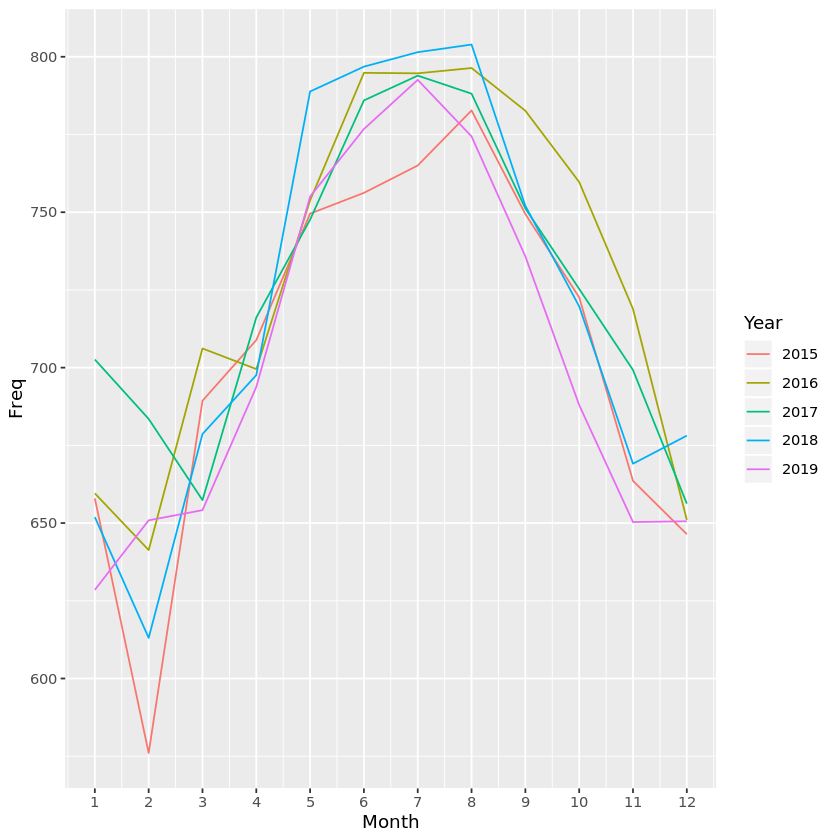

In [35]:
# Let's check the structure of the table
str(crimeFreq2)
#Plot lines
# Now we are going to aggregate the points to get only one point per month
crimeFreq2 <- mutate(crimeFreq2, MonthYear = paste(year(Dates),formatC(month(Dates), width = 2, flag = "0")))
Freq_month <- aggregate(crimeFreq2, by = list(crimeFreq2$MonthYear), FUN = function(x) mean(x, na.rm=T))
Freq_month$Year <- factor(Freq_month$Year)
                        
ggplot() + geom_line(data = Freq_month, aes(x = Month, y = Freq, color = Year))+ scale_x_continuous(breaks = 1:12)

# Mean in dataframes can bug out, hence the long error msg below

### Summary

As it can summarized, the there are notiable seasonal trends when most crime happen. Especially in the summer the crimes are at its peak, which now has been visualized and organized. \
The positive thing is that the trend is in a slight downward direction. 

# Cluster analysis

To respond to the crime activities in chicago we have made a cluster analysis using the k-means clustering to plot the location of three new police stations (Centers). Each station can respond to crimes within the marked areas (clusters).

The k-means clustering is appropriate to use in this case because we already know the number of clusters we want to have.

Creating dataframe with the needed columns.

In [36]:
ClusterData <- Dataset %>% select(Longitude, Latitude)
str(ClusterData)

'data.frame':	1328554 obs. of  2 variables:
 $ Longitude: num  NA NA NA NA NA NA NA NA NA NA ...
 $ Latitude : num  NA NA NA NA NA NA NA NA NA NA ...


We need to know how many empty data fields there is in the these columns.

In [37]:
colSums(is.na(ClusterData))

Longitude  Latitude 
    17899     17899

There's 17899 rows where no data have been provided by the chicago police. We remove these rows using na.omit and saves the filtered rows to the cluster dataframe

In [38]:
Cluster <- na.omit(ClusterData)
colSums(is.na(Cluster))

Longitude  Latitude 
        0         0

In [39]:
summary(Cluster)

   Longitude         Latitude    
 Min.   :-91,69   Min.   :36,62  
 1st Qu.:-87,71   1st Qu.:41,77  
 Median :-87,66   Median :41,86  
 Mean   :-87,67   Mean   :41,84  
 3rd Qu.:-87,63   3rd Qu.:41,91  
 Max.   :-87,52   Max.   :42,02  

We are using a the plot below to locate outliers. The outlier below isn't within the chicago city so we want to remove it.

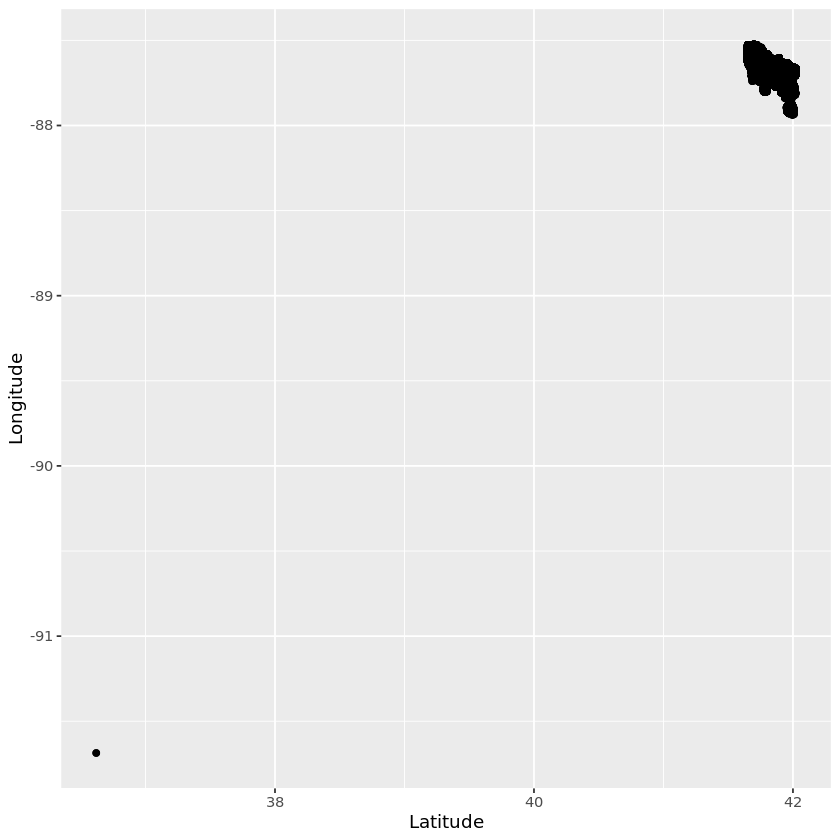

In [40]:
ggplot(Cluster, aes(x=Latitude, y = Longitude)) + geom_point()

In [41]:
#Remove outliers, which has been shown in above
Cluster <- Cluster[!Cluster$Latitude < 38 , ]

In [42]:
set.seed(123)
Cluster3 <- kmeans(Cluster, centers = 3)

We are using str and summary functions to get an understanding of what's inside of the algorithm

In [43]:
str(Cluster3)
summary(Cluster3)

List of 9
 $ cluster     : Named int [1:1310653] 2 3 1 3 1 3 3 1 1 3 ...
  ..- attr(*, "names")= chr [1:1310653] "14494" "14495" "14496" "14497" ...
 $ centers     : num [1:3, 1:2] -87,6 -87,7 -87,7 41,7 41,8 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:3] "1" "2" "3"
  .. ..$ : chr [1:2] "Longitude" "Latitude"
 $ totss       : num 14192
 $ withinss    : num [1:3] 801 887 2861
 $ tot.withinss: num 4548
 $ betweenss   : num 9643
 $ size        : int [1:3] 335414 317613 657626
 $ iter        : int 3
 $ ifault      : int 0
 - attr(*, "class")= chr "kmeans"


             Length  Class  Mode   
cluster      1310653 -none- numeric
centers            6 -none- numeric
totss              1 -none- numeric
withinss           3 -none- numeric
tot.withinss       1 -none- numeric
betweenss          1 -none- numeric
size               3 -none- numeric
iter               1 -none- numeric
ifault             1 -none- numeric

Now we can get the location of the police stations based on the center. These locations are expressed by longitude and latitude.

In [44]:
Cluster3$centers

Longitude,Latitude
"-87,61031","41,73614"
"-87,67060","41,80636"
"-87,70164","41,91631"


In [45]:
Cluster$Station <- as.factor(Cluster3$cluster)
PoliceStationLocation <- as.data.frame(Cluster3$centers)
PoliceStationLocation

Longitude,Latitude
"-87,61031","41,73614"
"-87,67060","41,80636"
"-87,70164","41,91631"


Now we can plot the clusters with the locations. 

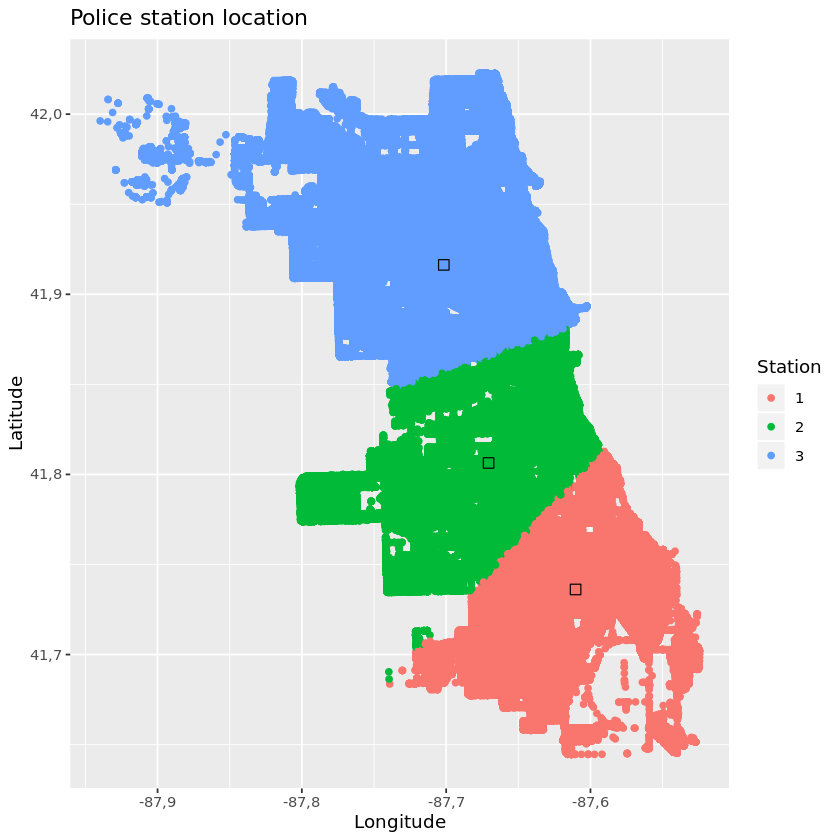

In [46]:
ggplot(Cluster) + geom_point(aes(x= Longitude, y = Latitude, colour = Station)) + 
  geom_point(data = PoliceStationLocation, aes(x = Longitude, y = Latitude), shape = 22, size = 3) +
  labs(title = "Police station location")

### Summary
We have now provided a map for the chicago police department. They can use this to effectively place the three police stations.

# Data storage

As for our case, we are dealing with just a couple of hundreds MB of data and if we look at the collected data of all crimes in Chicago back to 2001, it adds up to just shy of 2GB of data. 

This won’t cause any data storage problems or any of that sort. But this doesn’t mean that it can be optimized for the future. If the Chicago city wants to yield more summarized data and multidimensional views and faster query response times it can possible to invest in a data warehouse. 

As a function of business intelligence, a data warehouse uses Online Analytical Processing which allows managers and analysts to select, extract, view, and analyze the data to identify and obtain insights on seasonal trends as well as identify potential issues, which has been identified in this synopsis. 

It all depends on the needs of the stored data which system is needed. Databases are transaction oriented and data warehouses are built for analysis. Both are valuable and relies upon Chicago's needs. 

If Chicago processes digital transactions or collects data, they will need a database. However, if or when they must perform information examination to find patterns, improve experiences, or reveal issues, a data warehouse turns into a significant asset.

# Ethical discussion
The first problem that should be highlighted is the methodical approach when doing data analysis on large amounts of data. As data scientists, we need to follow ethical guidelines and principles to ensure that no one can be harmed from the results provided by the plots.  

As mentioned above the goal of this case is to get better use out of the data provided by the Chicago police department. An overview of the situation is needed to understand and predict. To do this we have been merging with another dataset to provide a summary of the evolution in crimes from 2015 to 2019. 
Linked to this case it is important to highlight the principle "Equality" which is mentioned in the book "DataEthics".

The principle is described as: "When processing data, special attention should be paid to vulnerable people, who are are particularly vulnerable to profiling that may adversely affect their self-determination and control or expose them to discrimination or stigmatization" (Tranberg et al. 2018, s. 12)

While there's no data in the columns that can directly lead to identifying a person that has either committed the crime or have been the victim of one some data can maybe lead to an actual identification. The "description" column is very descriptive and combining this data with other columns or dataframes might to lead to an identification of a person.

This raises the ethical question "Should this data be available for the public?". This question can be a hard one to answer however if the police department of Chicago uses the provided plots in this notebook they might prevent more crimes in the future and allocate future resources in the form of staff and material more effectively. Another problem arises here. "Who's using this data and for what purpose?" 
What if the data in this notebook were used by criminals, to locate where it would more sufficient to commit crimes?

"Algorithms must be explained in a way that individuals understand them" (Tranberg et al. 2018, s. 26)

On a final note we must also be aware of the principle "Explainability" when using algorithms to create forecasts, time series or k-means clustering. 

Used literature in this chapter:
Book: 
Title: "DataEthics"
Authors: Pernille Tranberg, Gry Hasselbalch, Birgitte Kofod Olsen & Catrine Søndergaard Byrne.
Year: 2018
Printed by: AKAPRINT A/S

# Final Conclusion

The final conclusion of this data analysis consists of many sub - conclusions. 

In the data cleaning chapter, we have managed to do the necessary cleaning for the making of data frames. we have accomplished to only remove NA's when needed. This is done to keep as much data as possible for the current analysis.

In the exploratory data analysis chapter we have concluded the following:
Theft is the most common type of crime with 310.847 cases from 2015 - 2019. 
The criminal activity is lower in 2019 compared to the past 4 years.
The Chicago police department needs to work more effectively when dealing with theft etc. where there's a lot of unsolved cases. 

As for the time-series analysis, there has been a focus on season trends in the crime frequency. During the time from 2015 - 2019, a slight downward direction has been shown in the frequency. To this, there are a lot more crimes happening on the 1st of January and a trend in the summer months of May to August. This is where it is wise to have more police officers on duty.
A forecast has also been made to show the direction of crime will take. 

In the Cluster analysis, we have accomplished to make good use of the k-means clustering. We have located the three best spots for the new police stations and also given them areas in which they can respond to crime activity.

The final statement is that we have provided the Chicago police department with an overview of some of the content in the dataset. 